In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import cProfile
from joblib import Parallel, delayed
from scipy.signal import butter, filtfilt, cheby2
from scipy import signal
from scipy.signal import decimate
#from __future__ import division

%matplotlib inline
%load_ext autoreload
import pywt
#import ruptures as rpt
#from pywt.waverec import icwt
import time
%autoreload 2
import matplotlib.lines as mlines
#import neurokit2 as nk
#import ruptures as rpt
#from pykalman import KalmanFilter
#import changefinder
import numpy as np
from scipy.interpolate import interp1d
import seaborn as sns
import mne
import matplotlib.pyplot as plt
from scipy.signal import welch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#import numpy as np
#from scipy.signal import butter, filtfilt, resample
#import mne

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
from Filters import chebyshev2_bandpass_filter, chebyshev2_high_filter, butter_lowpass_filter

In [3]:
#!pip install ruptures

In [24]:
#!pip install mne

     |████████████████████████████████| 6.9 MB 11.2 MB/s            


In [4]:
#!pip install neurokit2

In [5]:
#!pip install --upgrade pywavelets

In [6]:
from __future__ import division
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
#import bayesian_changepoint_detection.generate_data as gd
import seaborn

%matplotlib inline
%load_ext autoreload
%autoreload 2
from scipy import signal

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
#!pip install cvxopt

     |████████████████████████████████| 4.1 MB 14.6 MB/s            
  Installing build dependencies ... error
  ERROR: Command errored out with exit status 1:
   command: /usr/bin/python3.6 /usr/local/lib/python3.6/dist-packages/pip install --ignore-installed --no-user --prefix /tmp/pip-build-env-th9b3ss4/overlay --no-warn-script-location --no-binary :none: --only-binary :none: -i https://pypi.org/simple -- 'setuptools>=45' 'setuptools_scm[toml]>=6.2'
       cwd: None
  Complete output (12 lines):
  Traceback (most recent call last):
    File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
      "__main__", mod_spec)
    File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "/usr/local/lib/python3.6/dist-packages/pip/__main__.py", line 27, in <module>
      "ignore", category=DeprecationWarning, module=".*packaging\\.version"
    File "/usr/lib/python3.6/warnings.py", line 131, in filterwarnings
      import re
    File "/usr/

In [ ]:
import cvxopt as cv
import cvxopt.solvers

In [ ]:
import matplotlib as mpl
import pylab
from functools import partial
from matplotlib.lines import Line2D
import matplotlib.mlab as mlab
import matplotlib.gridspec as gridspec

mpl.rcParams['lines.linewidth'] = 4
mpl.rcParams['lines.color'] = 'r'
mpl.rcParams['font.weight'] = 200
plt.style.use('seaborn-whitegrid')
plt.rc('figure',figsize=(15,10))
mpl.axes.Axes.annotate
mpl.rcParams['font.family'] = "serif"
pylab.rcParams['ytick.major.pad']='10'
pylab.rcParams['xtick.major.pad']='10'
mpl.rcParams['font.weight'] = "semibold"
mpl.rcParams['axes.labelsize'] = 40
mpl.rcParams['axes.linewidth'] = 4
mpl.rcParams['xtick.labelsize'] = 40
mpl.rcParams['ytick.labelsize'] = 40
mpl.rcParams['axes.edgecolor'] = 'black'
mpl.rcParams['axes.titlesize'] = 40
mpl.rcParams['legend.fontsize'] = 40

In [8]:
def cvxEDA(y, delta, tau0=2., tau1=0.7, delta_knot=10., alpha=8e-4, gamma=1e-2,
           solver=None, options={'reltol':1e-9}):
    """CVXEDA Convex optimization approach to electrodermal activity processing
    This function implements the cvxEDA algorithm described in "cvxEDA: a
    Convex Optimization Approach to Electrodermal Activity Processing"
    (http://dx.doi.org/10.1109/TBME.2015.2474131, also available from the
    authors' homepages).
    Arguments:
       y: observed EDA signal (we recommend normalizing it: y = zscore(y))
       delta: sampling interval (in seconds) of y
       tau0: slow time constant of the Bateman function
       tau1: fast time constant of the Bateman function
       delta_knot: time between knots of the tonic spline function
       alpha: penalization for the sparse SMNA driver
       gamma: penalization for the tonic spline coefficients
       solver: sparse QP solver to be used, see cvxopt.solvers.qp
       options: solver options, see:
                http://cvxopt.org/userguide/coneprog.html#algorithm-parameters
    Returns (see paper for details):
       r: phasic component
       p: sparse SMNA driver of phasic component
       t: tonic component
       l: coefficients of tonic spline
       d: offset and slope of the linear drift term
       e: model residuals
       obj: value of objective function being minimized (eq 15 of paper)
    """

    n = len(y)
    y = cv.matrix(y)

    # bateman ARMA model
    a1 = 1./min(tau1, tau0) # a1 > a0
    a0 = 1./max(tau1, tau0)
    ar = np.array([(a1*delta + 2.) * (a0*delta + 2.), 2.*a1*a0*delta**2 - 8.,
        (a1*delta - 2.) * (a0*delta - 2.)]) / ((a1 - a0) * delta**2)
    ma = np.array([1., 2., 1.])

    # matrices for ARMA model
    i = np.arange(2, n)
    A = cv.spmatrix(np.tile(ar, (n-2,1)), np.c_[i,i,i], np.c_[i,i-1,i-2], (n,n))
    M = cv.spmatrix(np.tile(ma, (n-2,1)), np.c_[i,i,i], np.c_[i,i-1,i-2], (n,n))

    # spline
    delta_knot_s = int(round(delta_knot / delta))
    spl = np.r_[np.arange(1.,delta_knot_s), np.arange(delta_knot_s, 0., -1.)] # order 1
    spl = np.convolve(spl, spl, 'full')
    spl /= max(spl)
    # matrix of spline regressors
    i = np.c_[np.arange(-(len(spl)//2), (len(spl)+1)//2)] + np.r_[np.arange(0, n, delta_knot_s)]
    nB = i.shape[1]
    j = np.tile(np.arange(nB), (len(spl),1))
    p = np.tile(spl, (nB,1)).T
    valid = (i >= 0) & (i < n)
    B = cv.spmatrix(p[valid], i[valid], j[valid])

    # trend
    C = cv.matrix(np.c_[np.ones(n), np.arange(1., n+1.)/n])
    nC = C.size[1]

    # Solve the problem:
    # .5*(M*q + B*l + C*d - y)^2 + alpha*sum(A,1)*p + .5*gamma*l'*l
    # s.t. A*q >= 0

    old_options = cv.solvers.options.copy()
    cv.solvers.options.clear()
    cv.solvers.options.update(options)
    if solver == 'conelp':
        # Use conelp
        z = lambda m,n: cv.spmatrix([],[],[],(m,n))
        G = cv.sparse([[-A,z(2,n),M,z(nB+2,n)],[z(n+2,nC),C,z(nB+2,nC)],
                    [z(n,1),-1,1,z(n+nB+2,1)],[z(2*n+2,1),-1,1,z(nB,1)],
                    [z(n+2,nB),B,z(2,nB),cv.spmatrix(1.0, range(nB), range(nB))]])
        h = cv.matrix([z(n,1),.5,.5,y,.5,.5,z(nB,1)])
        c = cv.matrix([(cv.matrix(alpha, (1,n)) * A).T,z(nC,1),1,gamma,z(nB,1)])
        res = cv.solvers.conelp(c, G, h, dims={'l':n,'q':[n+2,nB+2],'s':[]})
        obj = res['primal objective']
    else:
        # Use qp
        Mt, Ct, Bt = M.T, C.T, B.T
        H = cv.sparse([[Mt*M, Ct*M, Bt*M], [Mt*C, Ct*C, Bt*C], 
                    [Mt*B, Ct*B, Bt*B+gamma*cv.spmatrix(1.0, range(nB), range(nB))]])
        f = cv.matrix([(cv.matrix(alpha, (1,n)) * A).T - Mt*y,  -(Ct*y), -(Bt*y)])
        res = cv.solvers.qp(H, f, cv.spmatrix(-A.V, A.I, A.J, (n,len(f))),
                            cv.matrix(0., (n,1)), solver=solver)
        obj = res['primal objective'] + .5 * (y.T * y)
    cv.solvers.options.clear()
    cv.solvers.options.update(old_options)

    l = res['x'][-nB:]
    d = res['x'][n:n+nC]
    t = B*l + C*d
    q = res['x'][:n]
    p = A * q
    r = M * q
    e = y - r - t

    return (np.array(a).ravel() for a in (r, p, t, l, d, e, obj))

In [93]:
df = pd.read_csv("Participant_1_Task_(Outdoor_2.0).csv", low_memory=False, skiprows=1)
df["Label"] = "Outdoor 1.0 Navigation"
df.head(5)

,Timestamp,OriginalTimestamp,EEG.Counter,EEG.Interpolated,EEG.AF3,EEG.T7,EEG.Pz,EEG.T8,EEG.AF4,EEG.RawCq,...,POW.T8.Alpha,POW.T8.BetaL,POW.T8.BetaH,POW.T8.Gamma,POW.AF4.Theta,POW.AF4.Alpha,POW.AF4.BetaL,POW.AF4.BetaH,POW.AF4.Gamma,Label
0,1.657507e+09,1.657507e+09,53.0,0.0,4246.153809,4203.077148,4120.512695,4148.205078,4239.487305,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Outdoor 1.0 Navigation
1,1.657507e+09,1.657507e+09,54.0,0.0,4234.358887,4184.615234,4108.205078,4144.615234,4228.205078,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Outdoor 1.0 Navigation
2,1.657507e+09,1.657507e+09,55.0,0.0,4229.743652,4182.563965,4111.794922,4140.512695,4217.436035,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Outdoor 1.0 Navigation
3,1.657507e+09,1.657507e+09,56.0,0.0,4226.153809,4201.025879,4120.000000,4145.641113,4219.487305,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Outdoor 1.0 Navigation
4,1.657507e+09,1.657507e+09,57.0,0.0,4216.410156,4205.128418,4124.615234,4151.282227,4216.922852,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Outdoor 1.0 Navigation


In [76]:
#temp_df = df.set_index('Timestamp') #set the timestamp column as index
#temp_re_df = temp_df["EEG.AF3"].resample('4s').mean()

In [94]:
df.head(3)

,Timestamp,OriginalTimestamp,EEG.Counter,EEG.Interpolated,EEG.AF3,EEG.T7,EEG.Pz,EEG.T8,EEG.AF4,EEG.RawCq,...,POW.T8.Alpha,POW.T8.BetaL,POW.T8.BetaH,POW.T8.Gamma,POW.AF4.Theta,POW.AF4.Alpha,POW.AF4.BetaL,POW.AF4.BetaH,POW.AF4.Gamma,Label
0,1.657507e+09,1.657507e+09,53.0,0.0,4246.153809,4203.077148,4120.512695,4148.205078,4239.487305,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Outdoor 1.0 Navigation
1,1.657507e+09,1.657507e+09,54.0,0.0,4234.358887,4184.615234,4108.205078,4144.615234,4228.205078,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Outdoor 1.0 Navigation
2,1.657507e+09,1.657507e+09,55.0,0.0,4229.743652,4182.563965,4111.794922,4140.512695,4217.436035,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Outdoor 1.0 Navigation


In [95]:
df.shape

(8251, 106)

In [97]:
df_seg = df[["EEG.AF3", "EEG.T7", "EEG.Pz", "EEG.T8", "EEG.AF4"]]

In [98]:
df_seg.shape

(7800, 5)

In [99]:
df_seg

,EEG.AF3,EEG.T7,EEG.Pz,EEG.T8,EEG.AF4
0,4246.153809,4203.077148,4120.512695,4148.205078,4239.487305
1,4234.358887,4184.615234,4108.205078,4144.615234,4228.205078
2,4229.743652,4182.563965,4111.794922,4140.512695,4217.436035
3,4226.153809,4201.025879,4120.000000,4145.641113,4219.487305
4,4216.410156,4205.128418,4124.615234,4151.282227,4216.922852
...,...,...,...,...,...
7795,4232.307617,4100.512695,4005.641113,4059.487061,4363.077148
7796,4229.743652,4114.871582,3996.923096,4053.846191,4348.205078
7797,4202.563965,4112.820313,3966.153809,4024.615479,4321.538574
7798,4176.922852,4098.461426,3950.769287,4003.076904,4305.128418


Creating RawArray with float64 data, n_channels=5, n_times=7800
    Range : 0 ... 7799 =      0.000 ...    60.930 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 423 samples (3.305 sec)

Fitting ICA to data using 5 channels (please be patient, this may take a while)
Selecting by number: 5 components
Fitting ICA took 0.0s.


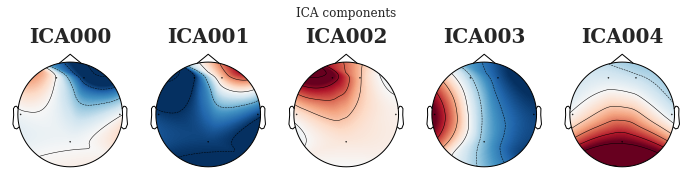

In [170]:
channel_names = ["EEG.AF3", "EEG.T7", "EEG.Pz", "EEG.T8", "EEG.AF4"]
sfreq = 128  


info = mne.create_info(ch_names=channel_names, sfreq=sfreq, ch_types="eeg")
raw = mne.io.RawArray(df_seg[channel_names].T.values, info)


montage = mne.channels.make_dig_montage(
    ch_pos={
        "EEG.AF3": [-0.03,  0.08,  0.03],  
        "EEG.T7":  [-0.09,  0.00,  0.00],  
        "EEG.Pz":  [ 0.00, -0.07,  0.07],  
        "EEG.T8":  [ 0.09,  0.00,  0.00],  
        "EEG.AF4": [ 0.03,  0.08,  0.03]   
    },
    coord_frame="head"
)
raw.set_montage(montage)

# **Apply High-Pass Filtering for ICA Stability**
raw.filter(l_freq=1.0, h_freq=30.0, method='fir')

# **Fit ICA**
ica_n_components = 0.99  
ica = mne.preprocessing.ICA(n_components=5, random_state=97, method="fastica", max_iter=1000)
ica.fit(raw)

fig = ica.plot_components(
    picks=range(5),          # Plot these 5 components
    sphere=(0.0, 0.0, 0.0, 0.095),            # Define the sphere model
    topomap_args=dict(extrapolate='box'),    # Control how topomap is extrapolated
    show=False, title=None               # Don't display immediately
)


for ax in fig.axes:
    current_title = ax.get_title()
    # Increase font size and use semibold weight
    ax.set_title(current_title, fontsize=20, fontweight='semibold')


#fig.suptitle("ICA Components in 2×3 Layout", fontsize=16, fontweight='semibold')

# Save the figure as PNG (300 DPI for high resolution)
fig.savefig("ica_component.png", dpi=300)


plt.show()


# figs = ica.plot_components(sphere=(0.0, 0.0, 0.0, 0.095),
#                            topomap_args=dict(extrapolate='box'),
#                            show=False)


# for i, fig in enumerate(figs):
#     fig.suptitle(f"ICA Component {i} Topography", fontsize=16, fontweight='bold')
#     #fig.savefig(f"ica_component_topography_{i}.png")
#     #plt.close(fig)  # Close the figure to free memory


# for fig in figs:
#     fig.show()

In [203]:
channel_names = ["EEG.AF3", "EEG.T7", "EEG.Pz", "EEG.T8", "EEG.AF4"]
sfreq = 128  
info = mne.create_info(ch_names=channel_names, sfreq=sfreq, ch_types="eeg")
raw = mne.io.RawArray(df_seg[channel_names].T.values, info)

montage = mne.channels.make_dig_montage(
    ch_pos={
        "EEG.AF3": [-0.03,  0.08,  0.03],  
        "EEG.T7":  [-0.09,  0.00,  0.00],  
        "EEG.Pz":  [ 0.00, -0.07,  0.07],  
        "EEG.T8":  [ 0.09,  0.00,  0.00],  
        "EEG.AF4": [ 0.03,  0.08,  0.03]   
    },
    coord_frame="head"
)
raw.set_montage(montage)
raw.filter(l_freq=1.0, h_freq=30.0, method='fir')

ica_n_components = 0.99  
ica = mne.preprocessing.ICA(n_components=5, random_state=97, method="fastica", max_iter=1000)
ica.fit(raw)

for ic in range(ica.n_components_):
    figs = ica.plot_properties(
        raw,
        picks=[ic],
        psd_args={'fmax': 40},
        show=False,
        topomap_args=dict(
            sphere=(0.0, 0.0, 0.0, 0.095),
            extrapolate='local',
            res=32
        ),
        figsize=(15, 15)  
    )

    fig = figs[0]
    
    #fig.suptitle(f"ICA Component {ic:03d}", fontsize=16, fontweight='semibold')
    

    #fig.tight_layout(rect=[0, 0, 1, 0.95])

    #fig.savefig(f"ICA_Component_{ic:03d}.png", dpi=300, bbox_inches='tight')
    plt.close(fig)

print("Saved ICA component property plots for each component.")

Creating RawArray with float64 data, n_channels=5, n_times=7800
    Range : 0 ... 7799 =      0.000 ...    60.930 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 423 samples (3.305 sec)

Fitting ICA to data using 5 channels (please be patient, this may take a while)
Selecting by number: 5 components
Fitting ICA took 0.0s.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
30 matching events found
No baseline correction applied
0 projection ite

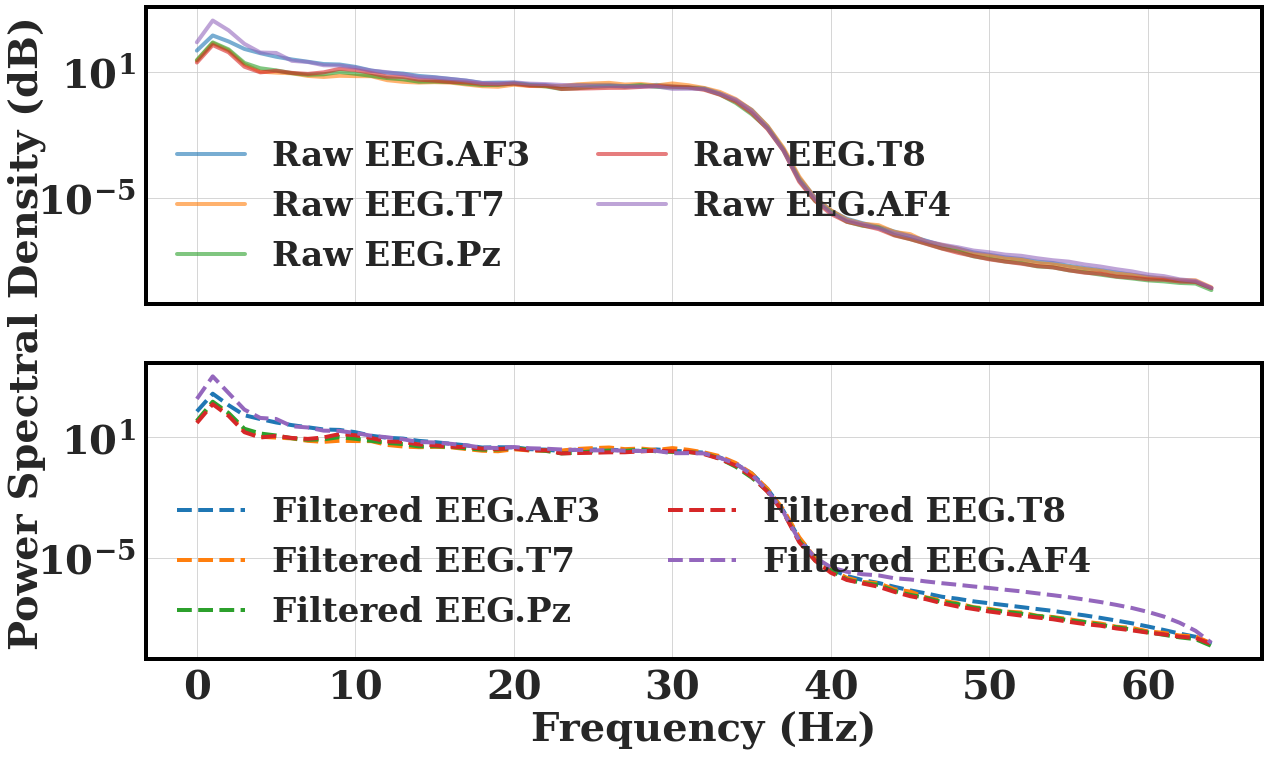

In [174]:
def compute_psd(eeg_data, sfreq, nperseg=128):
    psd_list = []
    freqs = None
    for i in range(eeg_data.shape[0]): 
        freqs, psd = welch(eeg_data[i], fs=sfreq, nperseg=nperseg)
        psd_list.append(psd)
    return np.array(psd_list), freqs

#
psd_raw, freqs = compute_psd(raw.get_data(), sfreq)


psd_filtered, freqs_filtered = compute_psd(raw_filtered.get_data(), sfreq)

fig, axes = plt.subplots(2, 1, figsize=(20, 12), sharex=True)


#axes[0].set_title("PSD of Raw EEG Signals")
for i, ch in enumerate(channel_names):
    axes[0].semilogy(freqs, psd_raw[i], label=f'Raw {ch}', alpha=0.6, linestyle='solid')
axes[0].set_ylabel("Power Spectral Density (dB)", fontweight='semibold')
axes[0].yaxis.set_label_coords(-0.09, -0.1)
axes[0].legend(ncol =2, fontsize=34)
axes[0].grid(True)


#axes[1].set_title("PSD of Filtered EEG Signals (0.1 - 30 Hz)")
for i, ch in enumerate(channel_names):
    axes[1].semilogy(freqs_filtered, psd_filtered[i], label=f'Filtered {ch}', linestyle='dashed')
axes[1].set_xlabel("Frequency (Hz)", fontweight='semibold')
#axes[1].set_ylabel("Power Spectral Density (dB)")
axes[1].legend(ncol =2, fontsize=34)

axes[1].grid(True)

#plt.savefig("EEG_PSD_plot.png", format='png', bbox_inches='tight', dpi=300)
plt.show()

In [191]:
def compute_psd(eeg_data, sfreq, nperseg=32):
    psd_list = []
    freqs = None
    for i in range(eeg_data.shape[0]):  # Loop over each channel
        freqs, psd = welch(eeg_data[i], fs=sfreq, nperseg=nperseg)
        psd_list.append(psd)
    return np.array(psd_list), freqs

# Compute PSD for raw EEG data
psd_raw, freqs = compute_psd(raw.get_data(), sfreq)

# Compute PSD for filtered EEG data
psd_filtered, freqs_filtered = compute_psd(raw_filtered.get_data(), sfreq)

# **Plot and Save PSD for Raw EEG Data**
plt.figure(figsize=(8, 8))
for i, ch in enumerate(channel_names):
    plt.semilogy(freqs, psd_raw[i], label=f'Raw {ch}', alpha=0.6, linestyle='solid')

plt.xlabel("Frequency (Hz)",  fontweight='semibold', fontsize=40)
plt.ylabel("PSD (dB)", fontweight='semibold', fontsize=40)
plt.legend(ncol =1, fontsize=33)
plt.grid(True)
#plt.title("PSD of Raw EEG Signals", fontweight='bold')
plt.savefig("EEG_PSD_Raw.png", format='png', bbox_inches='tight', dpi=300)  # Save raw EEG PSD
plt.close()
plt.show()

plt.figure(figsize=(8, 8))
for i, ch in enumerate(channel_names):
    plt.semilogy(freqs_filtered, psd_filtered[i], label=f'Filtered {ch}', linestyle='dashed')

plt.xlabel("Frequency (Hz)",  fontweight='semibold', fontsize=40)
plt.ylabel("PSD (dB)", fontweight='semibold', fontsize=40)
plt.legend(ncol =1, fontsize=33)
plt.grid(True)
#plt.title("PSD of Filtered EEG Signals (0.1 - 30 Hz)", fontweight='bold')
plt.savefig("EEG_PSD_Filtered.png", format='png', bbox_inches='tight', dpi=300)  # Save filtered EEG PSD
plt.close()
plt.show()

print("Saved: EEG_PSD_Raw.png & EEG_PSD_Filtered.png")

Saved: EEG_PSD_Raw.png & EEG_PSD_Filtered.png


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 0.9 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 0.90 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.90 Hz)
- Filter length: 845 samples (6.602 sec)



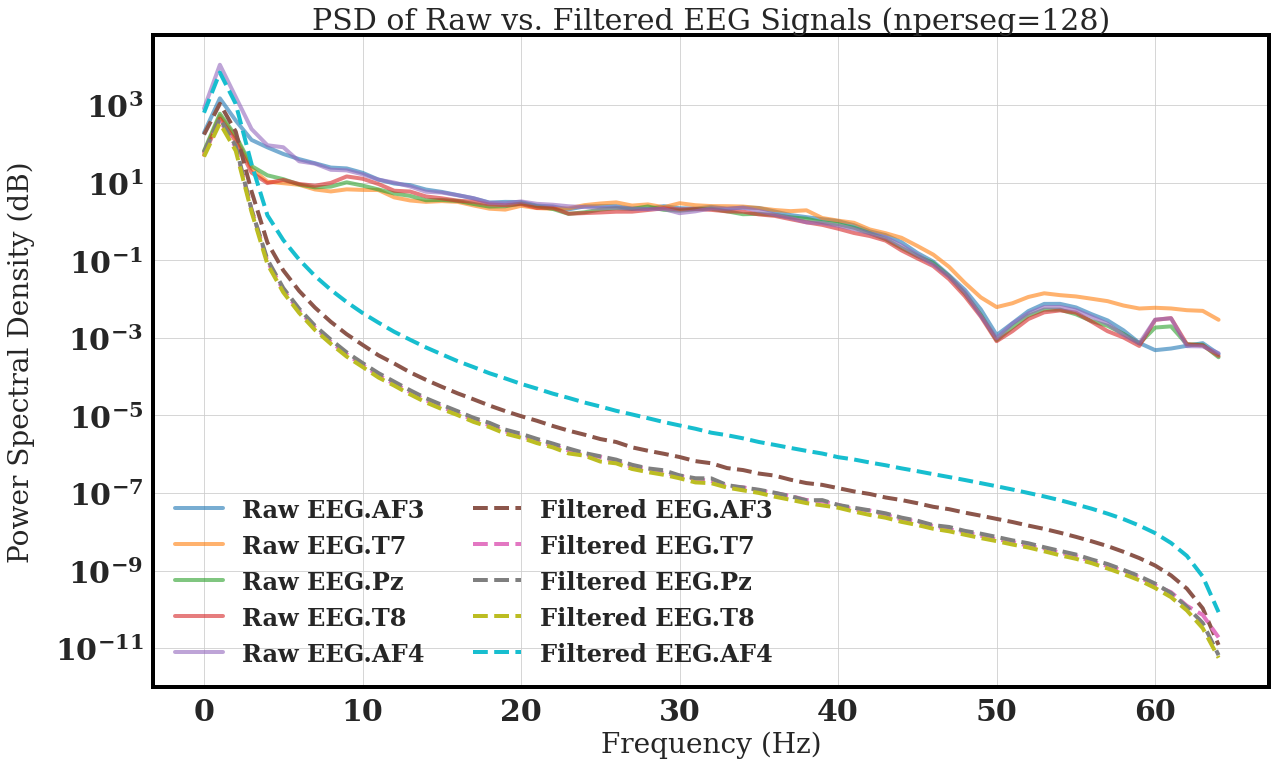

In [64]:
# Re-run the PSD computation with the new `nperseg=128`
def compute_psd(eeg_data, sfreq, nperseg=128):
    psd_list = []
    freqs = None
    for i in range(eeg_data.shape[0]):  # Loop over each channel
        freqs, psd = welch(eeg_data[i], fs=sfreq, nperseg=nperseg)
        psd_list.append(psd)
    return np.array(psd_list), freqs

# Apply bandpass filter (0.1 - 30 Hz) on raw EEG data
low_cut = 0.5
hi_cut = 0.9
raw_filtered = raw.copy().filter(l_freq=low_cut, h_freq=hi_cut, method='fir')

# Compute PSD for raw and filtered EEG data with nperseg=128
psd_raw, freqs = compute_psd(raw.get_data(), sfreq, nperseg=128)
psd_filtered, freqs_filtered = compute_psd(raw_filtered.get_data(), sfreq, nperseg=128)

# Create a single plot with two overlaid subplots sharing the same x and y axes
fig, ax = plt.subplots(figsize=(20, 12))

# Plot PSD for Raw EEG Data
for i, ch in enumerate(channel_names):
    ax.semilogy(freqs, psd_raw[i], label=f'Raw {ch}', alpha=0.6, linestyle='solid')

# Plot PSD for Filtered EEG Data
for i, ch in enumerate(channel_names):
    ax.semilogy(freqs_filtered, psd_filtered[i], label=f'Filtered {ch}', linestyle='dashed')

ax.set_xlabel("Frequency (Hz)", fontsize=28)
ax.set_ylabel("Power Spectral Density (dB)", fontsize=28, labelpad=20)  # Adjust Y-axis position
ax.set_title("PSD of Raw vs. Filtered EEG Signals (nperseg=128)", fontsize=30)
ax.legend(ncol=2, fontsize=24, loc='best')
ax.grid(True)

plt.show()


In [310]:
df1 = pd.read_csv("Participant_Indoor_INSIGHT_163004_2022.07.13T13.04.02.04.00.md.mc.pm.fe.bp.csv", low_memory=False, skiprows=1)
df1["Label"] = "Outdoor 1.0 Navigation"
df1.head(5)

,Timestamp,OriginalTimestamp,EEG.Counter,EEG.Interpolated,EEG.AF3,EEG.T7,EEG.Pz,EEG.T8,EEG.AF4,EEG.RawCq,...,POW.T8.Alpha,POW.T8.BetaL,POW.T8.BetaH,POW.T8.Gamma,POW.AF4.Theta,POW.AF4.Alpha,POW.AF4.BetaL,POW.AF4.BetaH,POW.AF4.Gamma,Label
0,1.657732e+09,1.657732e+09,83.0,0.0,4333.333496,4703.589844,4178.461426,4258.974121,4498.461426,1023.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Outdoor 1.0 Navigation
1,1.657732e+09,1.657732e+09,84.0,0.0,4296.410156,4730.256348,4160.512695,4250.769043,4529.230957,450.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Outdoor 1.0 Navigation
2,1.657732e+09,1.657732e+09,85.0,0.0,4155.384766,4627.692383,4191.282227,4248.205078,4452.820313,450.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Outdoor 1.0 Navigation
3,1.657732e+09,1.657732e+09,86.0,0.0,4098.974121,4516.922852,4187.179688,4253.333496,4412.307617,450.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Outdoor 1.0 Navigation
4,1.657732e+09,1.657732e+09,87.0,0.0,4023.589844,4469.743652,4203.589844,4253.846191,4399.487305,1023.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Outdoor 1.0 Navigation


In [311]:
df1.shape
df1 = df1.iloc[:7800, :]
df_seg1 = df1[["EEG.AF3", "EEG.T7", "EEG.Pz", "EEG.T8", "EEG.AF4"]]
df_seg1.shape

(7800, 5)

In [312]:
scaler = MinMaxScaler()
df_seg  = scaler.fit_transform(df_seg)

scaler = MinMaxScaler()
df_seg1  = scaler.fit_transform(df_seg1)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


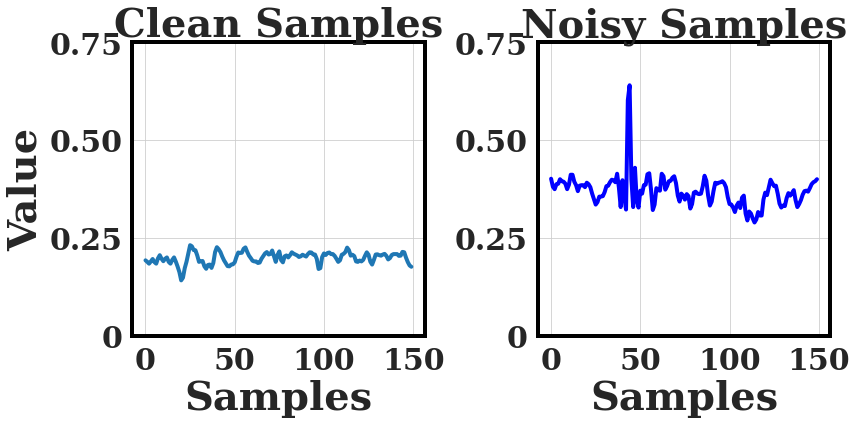

In [323]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(df_seg[0:150, 3])
plt.title('Clean Samples',fontweight='semibold', fontsize = '40')
plt.xlabel('Samples', fontweight='semibold', fontsize = '40')
#plt.ylabel('Value')
plt.ylabel('Value', fontweight='semibold', fontsize = '40')
plt.xticks([0, 50, 100, 150], ['0', '50', '100', '150'], fontweight='semibold', fontsize = '30')
plt.yticks([0, 0.25, 0.50, 0.75], ['0', '0.25', '0.50', '0.75'], fontweight='semibold', fontsize = '30')
#plt.yticks(fontweight='semibold', fontsize = '30')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(df_seg1[0:150, 3], linestyle='-', color='b')
plt.title('Noisy Samples', fontweight='semibold', fontsize = '40')
plt.xlabel('Samples', fontweight='semibold', fontsize = '40')
plt.xticks([0, 50, 100, 150], ['0', '50', '100', '150'], fontweight='semibold', fontsize = '30')
plt.yticks([0, 0.25, 0.50, 0.75], ['0', '0.25', '0.50', '0.75'], fontweight='semibold', fontsize = '30')
#plt.yticks(fontweight='semibold', fontsize = '30')
plt.legend()

#ax = plt.gca()  # Get current axes
#ax.set_xticklabels(['0', '25', '50', '75','100', '125', '150'], fontsize='20')  # Set y-tick labe

plt.tight_layout()
plt.savefig("Motivation_WM_Dataset.png", format='png',dpi=300,bbox_inches='tight')
plt.show()

In [10]:
df1 = pd.read_csv("CogMem2day.csv", sep ='\t', skiprows = 3, header = None)

In [11]:
df1.columns =["Timestamp", "Accel_LN_X_CAL", "Accel_LN_Y_CAL", "Accel_LN_Z_CAL", "Accel_WR_X_CAL" ,"Accel_WR_Y_CAL","Accel_WR_Z_CAL",
            "Shimmer_B00E_GSR_Range_CAL","Shimmer_B00E_GSR_Skin_Conductance_CAL","Shimmer_B00E_GSR_Skin_Resistance_CAL","Gyro_X_CAL",
              "Gyro_Y_CAL","Gyro_Z_CAL","Mag_X_CAL","Mag_Y_CAL","Mag_Z_CAL","PPG_Cal","Nan"]

In [12]:
df1 = df1.drop(["Shimmer_B00E_GSR_Skin_Resistance_CAL", "Nan","Shimmer_B00E_GSR_Range_CAL","Accel_LN_X_CAL", "Accel_LN_Y_CAL", "Accel_LN_Z_CAL", "Accel_WR_X_CAL" ,"Accel_WR_Y_CAL","Accel_WR_Z_CAL",
               "Gyro_X_CAL", "Gyro_Y_CAL","Gyro_Z_CAL","Mag_X_CAL","Mag_Y_CAL","Mag_Z_CAL", "Nan"], axis =1)

In [13]:
df1.head(3)

,Timestamp,Shimmer_B00E_GSR_Skin_Conductance_CAL,PPG_Cal
0,2022/07/11 18:52:40.244,0.000222,1274.725275
1,2022/07/11 18:52:40.276,0.000222,1327.472527
2,2022/07/11 18:52:40.307,0.000222,1253.479853


In [14]:
d=df1[(df1['Timestamp'] > "2022/07/11 19:10:30") & (df1['Timestamp'] < "2022/07/11 19:11:42:40")]

In [15]:
d.shape

(2336, 3)

In [16]:
d = d.iloc[:1950, :]

In [17]:
d.head(5)

,Timestamp,Shimmer_B00E_GSR_Skin_Conductance_CAL,PPG_Cal
34233,2022/07/11 19:10:30.026,0.580531,296.703297
34234,2022/07/11 19:10:30.057,0.580531,295.970696
34235,2022/07/11 19:10:30.088,0.580531,296.703297
34236,2022/07/11 19:10:30.119,0.580531,295.970696
34237,2022/07/11 19:10:30.151,0.580531,295.970696


In [18]:
d = d.drop(["Timestamp"], axis =1)

In [198]:
def normalize(X_Raw_Data):
    result = d.copy()
    for feature_name in d.columns:
        max_value = d[feature_name].max()
        min_value = d[feature_name].min()
        result[feature_name] = (d[feature_name] - min_value) / (max_value - min_value)
    return result

In [69]:
d = normalize(d)

In [19]:
cb = np.array(d['Shimmer_B00E_GSR_Skin_Conductance_CAL']) 
bd = np.array(d['PPG_Cal']) 
cb = cb.reshape(-1)
cb = list(cb)

In [71]:
butter_lowpass_filter(bd, 2, 32, order=2)

array([-7.21731993e-05, -6.15019589e-02,  2.97121474e-02, ...,
       -1.43847557e-01, -1.11419951e-01, -6.88815293e-03])

In [72]:
signals, info = nk.eda_process(cb, sampling_rate=32)
signal, info = nk.ppg_process(bd , sampling_rate=100)
#signal

In [73]:
def apply_bandpass_filter(signal, low_cutoff_freq, high_cutoff_freq, sampling_freq, order=4):
    nyquist_freq = 0.5 * sampling_freq
    low_normalized_cutoff = low_cutoff_freq / nyquist_freq
    high_normalized_cutoff = high_cutoff_freq / nyquist_freq
    b, a = butter(order, [low_normalized_cutoff, high_normalized_cutoff], btype='band', analog=False)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# Apply band-pass filter with cutoff frequencies of 2 Hz and 5 Hz
filtered_signal = apply_bandpass_filter(bd, low_cutoff_freq=4, high_cutoff_freq=12, sampling_freq=200)

In [74]:
def apply_chebyshev2_filter(signal, cutoff_freq, sampling_freq, rp, rs, btype='high', order=4):
    nyquist_freq = 0.5 * sampling_freq
    normalized_cutoff = cutoff_freq / nyquist_freq
    b, a = cheby2(order, rs, normalized_cutoff, btype=band, analog=False)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

In [117]:
filtered_signal.shape

(1950,)

In [210]:
Multi_Modal =  np.column_stack((filtered_signal, signals['EDA_Phasic'],eeg_signal_downsampled))

In [211]:
r = signals['EDA_Phasic']

In [212]:
Multi_Modal.shape

(1950, 7)

In [213]:
r.shape

(1950,)

In [272]:
result.shape

(300,)

In [273]:
#resul = normalize(result)
#scaler = MinMaxScaler()
#resul = scaler.fit_transform(result)

result = result.values.reshape(-1, 1)

# Now, use MinMaxScaler
scaler = MinMaxScaler()
resul = scaler.fit_transform(result)

In [274]:
resul.shape

(300, 1)

In [ ]:
bd.shape

In [ ]:
signals, info = nk.eda_process(cb, sampling_rate=32)
signal, info = nk.ppg_process(filtered_signal , sampling_rate=32)
signal
#signal
#signal = signals[["EDA_Raw","EDA_Clean","EDA_Tonic","EDA_Phasic"]]

In [ ]:
column_range = (signal['PPG_Rate'].min(), signal['PPG_Rate'].max())
column_range

In [ ]:
signal, info = nk.ppg_process(filtered_signal , sampling_rate=32)
signal

In [ ]:
column_range = (signal['PPG_Rate'].min(), signal['PPG_Rate'].max())
column_range

In [ ]:
signal['PPG_Rate'].plot()

In [ ]:
#peaks = nk.ppg_findpeaks(bd, sampling_rate=32, show=True)

In [ ]:
#nk.ppg_plot(signal)

In [ ]:
#ppg = nk.ppg_simulate(duration=10, sampling_rate=1000, heart_rate=70)

signals, info = nk.ppg_process(cb, sampling_rate=1000)

In [ ]:
preprocessed_ppg = nk.ppg_clean(cb)

peaks = nk.ppg_findpeaks(preprocessed_ppg)

# Calculate inter-beat intervals (IBI) from the peaks
ibi = nk.ppg_to_ibis(peaks["PPG_Peaks"])

# Calculate heart rate (BPM) from the IBIs
heart_rate = 60 / nk.mean(ibi)

print(heart_rate)

In [ ]:
signal['PPG_Rate'].plot()

In [ ]:
column_range = (signal['PPG_Rate'].min(), signal['PPG_Rate'].max())
column_range

In [ ]:
range_values = signal.max() - signal.min()
range_values

In [20]:
def apply_lowpass_filter(signal, cutoff_freq, sampling_freq, order=2):
    nyquist_freq = 0.5 * sampling_freq
    normalized_cutoff = cutoff_freq / nyquist_freq
    b, a = butter(order, normalized_cutoff, btype='high', analog=False)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

In [21]:
def apply_chebyshev2_filter(signal, cutoff_freq, sampling_freq, rp, rs, btype='high', order=4):
    nyquist_freq = 0.5 * sampling_freq
    normalized_cutoff = cutoff_freq / nyquist_freq
    b, a = cheby2(order, rs, normalized_cutoff, btype='high', analog=False)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

In [22]:
cb = np.array(d['Shimmer_B00E_GSR_Skin_Conductance_CAL']) 
bd = np.array(d['PPG_Cal'])

In [23]:
cb.shape

(1950,)

In [24]:
bd.shape

(1950,)

In [30]:
signal, info = nk.ppg_process(bd , sampling_rate=32)

/usr/local/lib/python3.6/dist-packages/neurokit2/signal/signal_period.py:62: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  category=NeuroKitWarning


<AxesSubplot:title={'center':'Heart Rate'}, xlabel='Samples'>

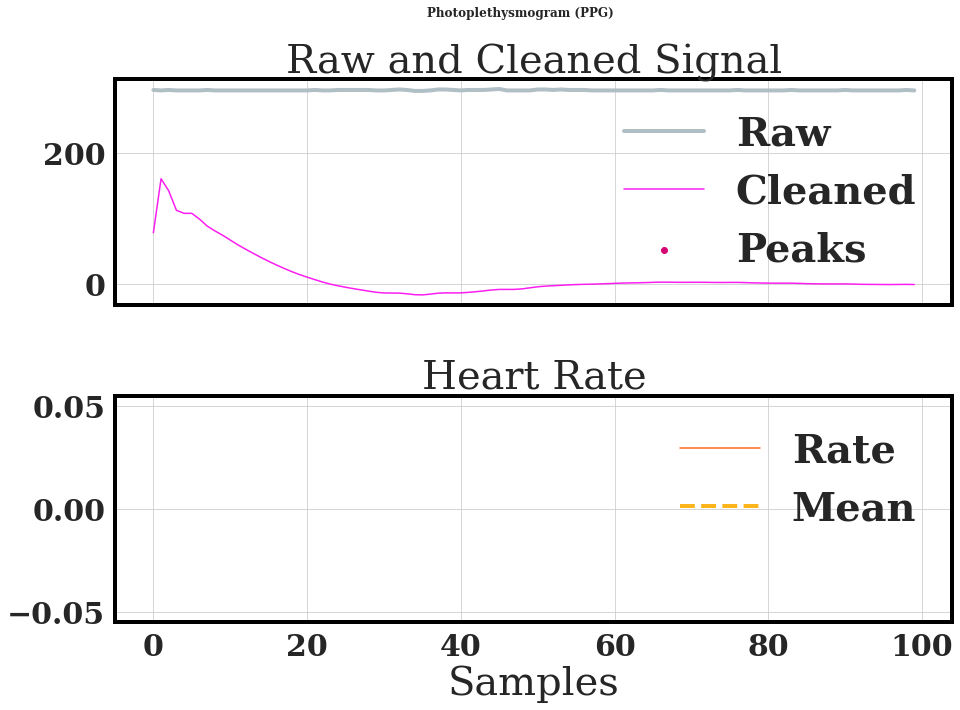

In [33]:
#plt.plot(signal, label='Raw PPG Signal')
nk.ppg_plot(signal[0:100])
column_range = (signal['PPG_Rate'].min(), signal['PPG_Rate'].max())
column_range
signal['PPG_Rate'].plot()

In [34]:
preprocessed_ppg = nk.ppg_clean(cb)

peaks = nk.ppg_findpeaks(preprocessed_ppg)

# Calculate inter-beat intervals (IBI) from the peaks
ibi = nk.ppg_to_ibis(peaks["PPG_Peaks"])

# Calculate heart rate (BPM) from the IBIs
heart_rate = 60 / nk.mean(ibi)

print(heart_rate)

AttributeError: module 'neurokit2' has no attribute 'ppg_to_ibis'

In [40]:
ppg = nk.ppg_simulate(heart_rate=75, duration=30)

In [41]:
ppg_elgendi = nk.ppg_clean(ppg, method='elgendi')

<AxesSubplot:>

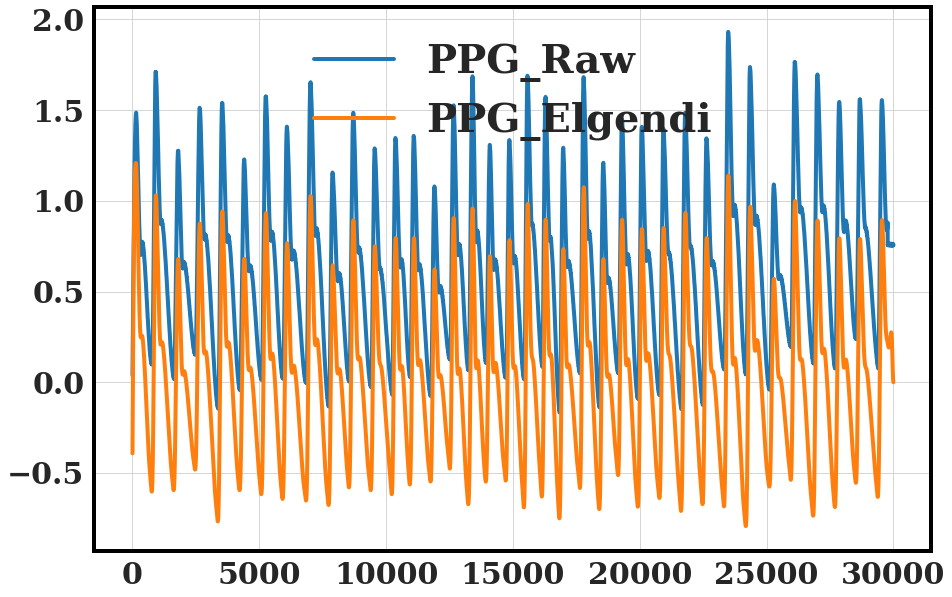

In [42]:
signals = pd.DataFrame({'PPG_Raw' : ppg,
                        'PPG_Elgendi' : ppg_elgendi})
signals.plot()

In [46]:
#plt.plot(bd, label='Raw PPG Signal')